# Image Classification using CNN

# dataset: CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# load CIFAR10 with torchvision
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 51403498.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


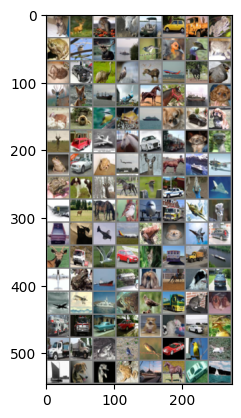

dog   deer  bird  deer  ship  car   truck frog  frog  bird  deer  ship  bird  bird  bird  cat   dog   car   bird  bird  deer  plane horse bird  deer  dog   ship  plane horse horse ship  dog   deer  dog   bird  frog  ship  dog   car   dog   deer  car   plane horse car   truck dog   bird  frog  car   frog  plane deer  horse ship  plane frog  dog   deer  horse bird  car   bird  plane plane deer  horse bird  plane truck plane bird  truck cat   plane plane frog  dog   plane car   deer  truck bird  car   cat   truck truck ship  plane frog  ship  truck dog   horse dog   car   plane plane ship  frog  bird  truck cat   dog   truck truck car   car   dog   dog   car   deer  truck truck frog  bird  bird  car   bird  cat   ship  dog   bird  frog  ship  horse car   ship 


In [3]:
# visulaize some of the training images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Implement a CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
model = Cifar10CnnModel()

use gpu

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)
to_device(model, device);

# Train the model

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
model = to_device(Cifar10CnnModel(), device)

Evaluate the model with randomly created weights. The accuracy is 10%, which makes sense since we have 10 classes.

In [13]:
evaluate(model, testloader)

{'val_loss': 2.303112268447876, 'val_acc': 0.1002769023180008}

hyperparameters

In [14]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [15]:
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.6643, val_loss: 1.2569, val_acc: 0.5279
Epoch [1], train_loss: 1.0726, val_loss: 0.9372, val_acc: 0.6688
Epoch [2], train_loss: 0.8091, val_loss: 0.8037, val_acc: 0.7156
Epoch [3], train_loss: 0.6382, val_loss: 0.7010, val_acc: 0.7604
Epoch [4], train_loss: 0.5051, val_loss: 0.7210, val_acc: 0.7640
Epoch [5], train_loss: 0.3979, val_loss: 0.7073, val_acc: 0.7706
Epoch [6], train_loss: 0.2987, val_loss: 0.7312, val_acc: 0.7787
Epoch [7], train_loss: 0.2198, val_loss: 0.8079, val_acc: 0.7861
Epoch [8], train_loss: 0.1711, val_loss: 0.8601, val_acc: 0.7813
Epoch [9], train_loss: 0.1372, val_loss: 0.9737, val_acc: 0.7790


plot the valiadation accuracies

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

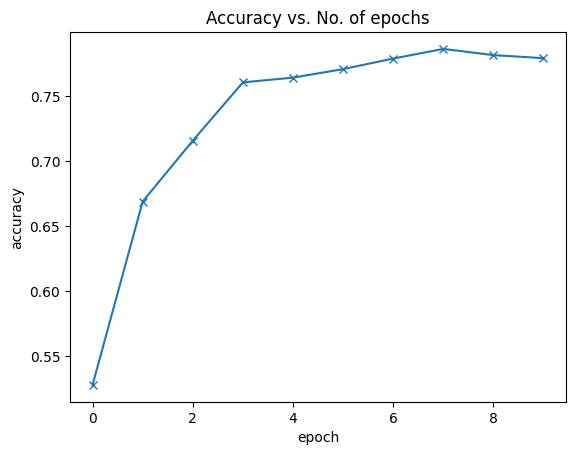

In [17]:
plot_accuracies(history)

plot the training and validation losses

In [18]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

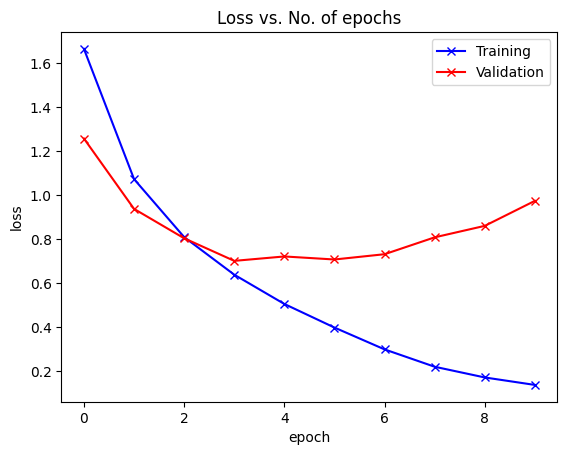

In [19]:
plot_losses(history)